In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [3]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


# lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
# lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

# if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
#     file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
# elif os.environ['NAME'] == 'LaNaranjaDos':
#     file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
# else: raise Exception('Device not configured for hdf5 data load')

# LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
# LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

In [4]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

# ANNz run performace (PAUS_advanced10, BDT)

In [8]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced10/ANNZ_randomReg_0000.csv',header=0)
indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 6.90e-04 
st. dev of normed error                       = 0.046
Percentage of 'catastrophic' outliers         = 1.663%
half width of 68th percentile of normed error = 0.029


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


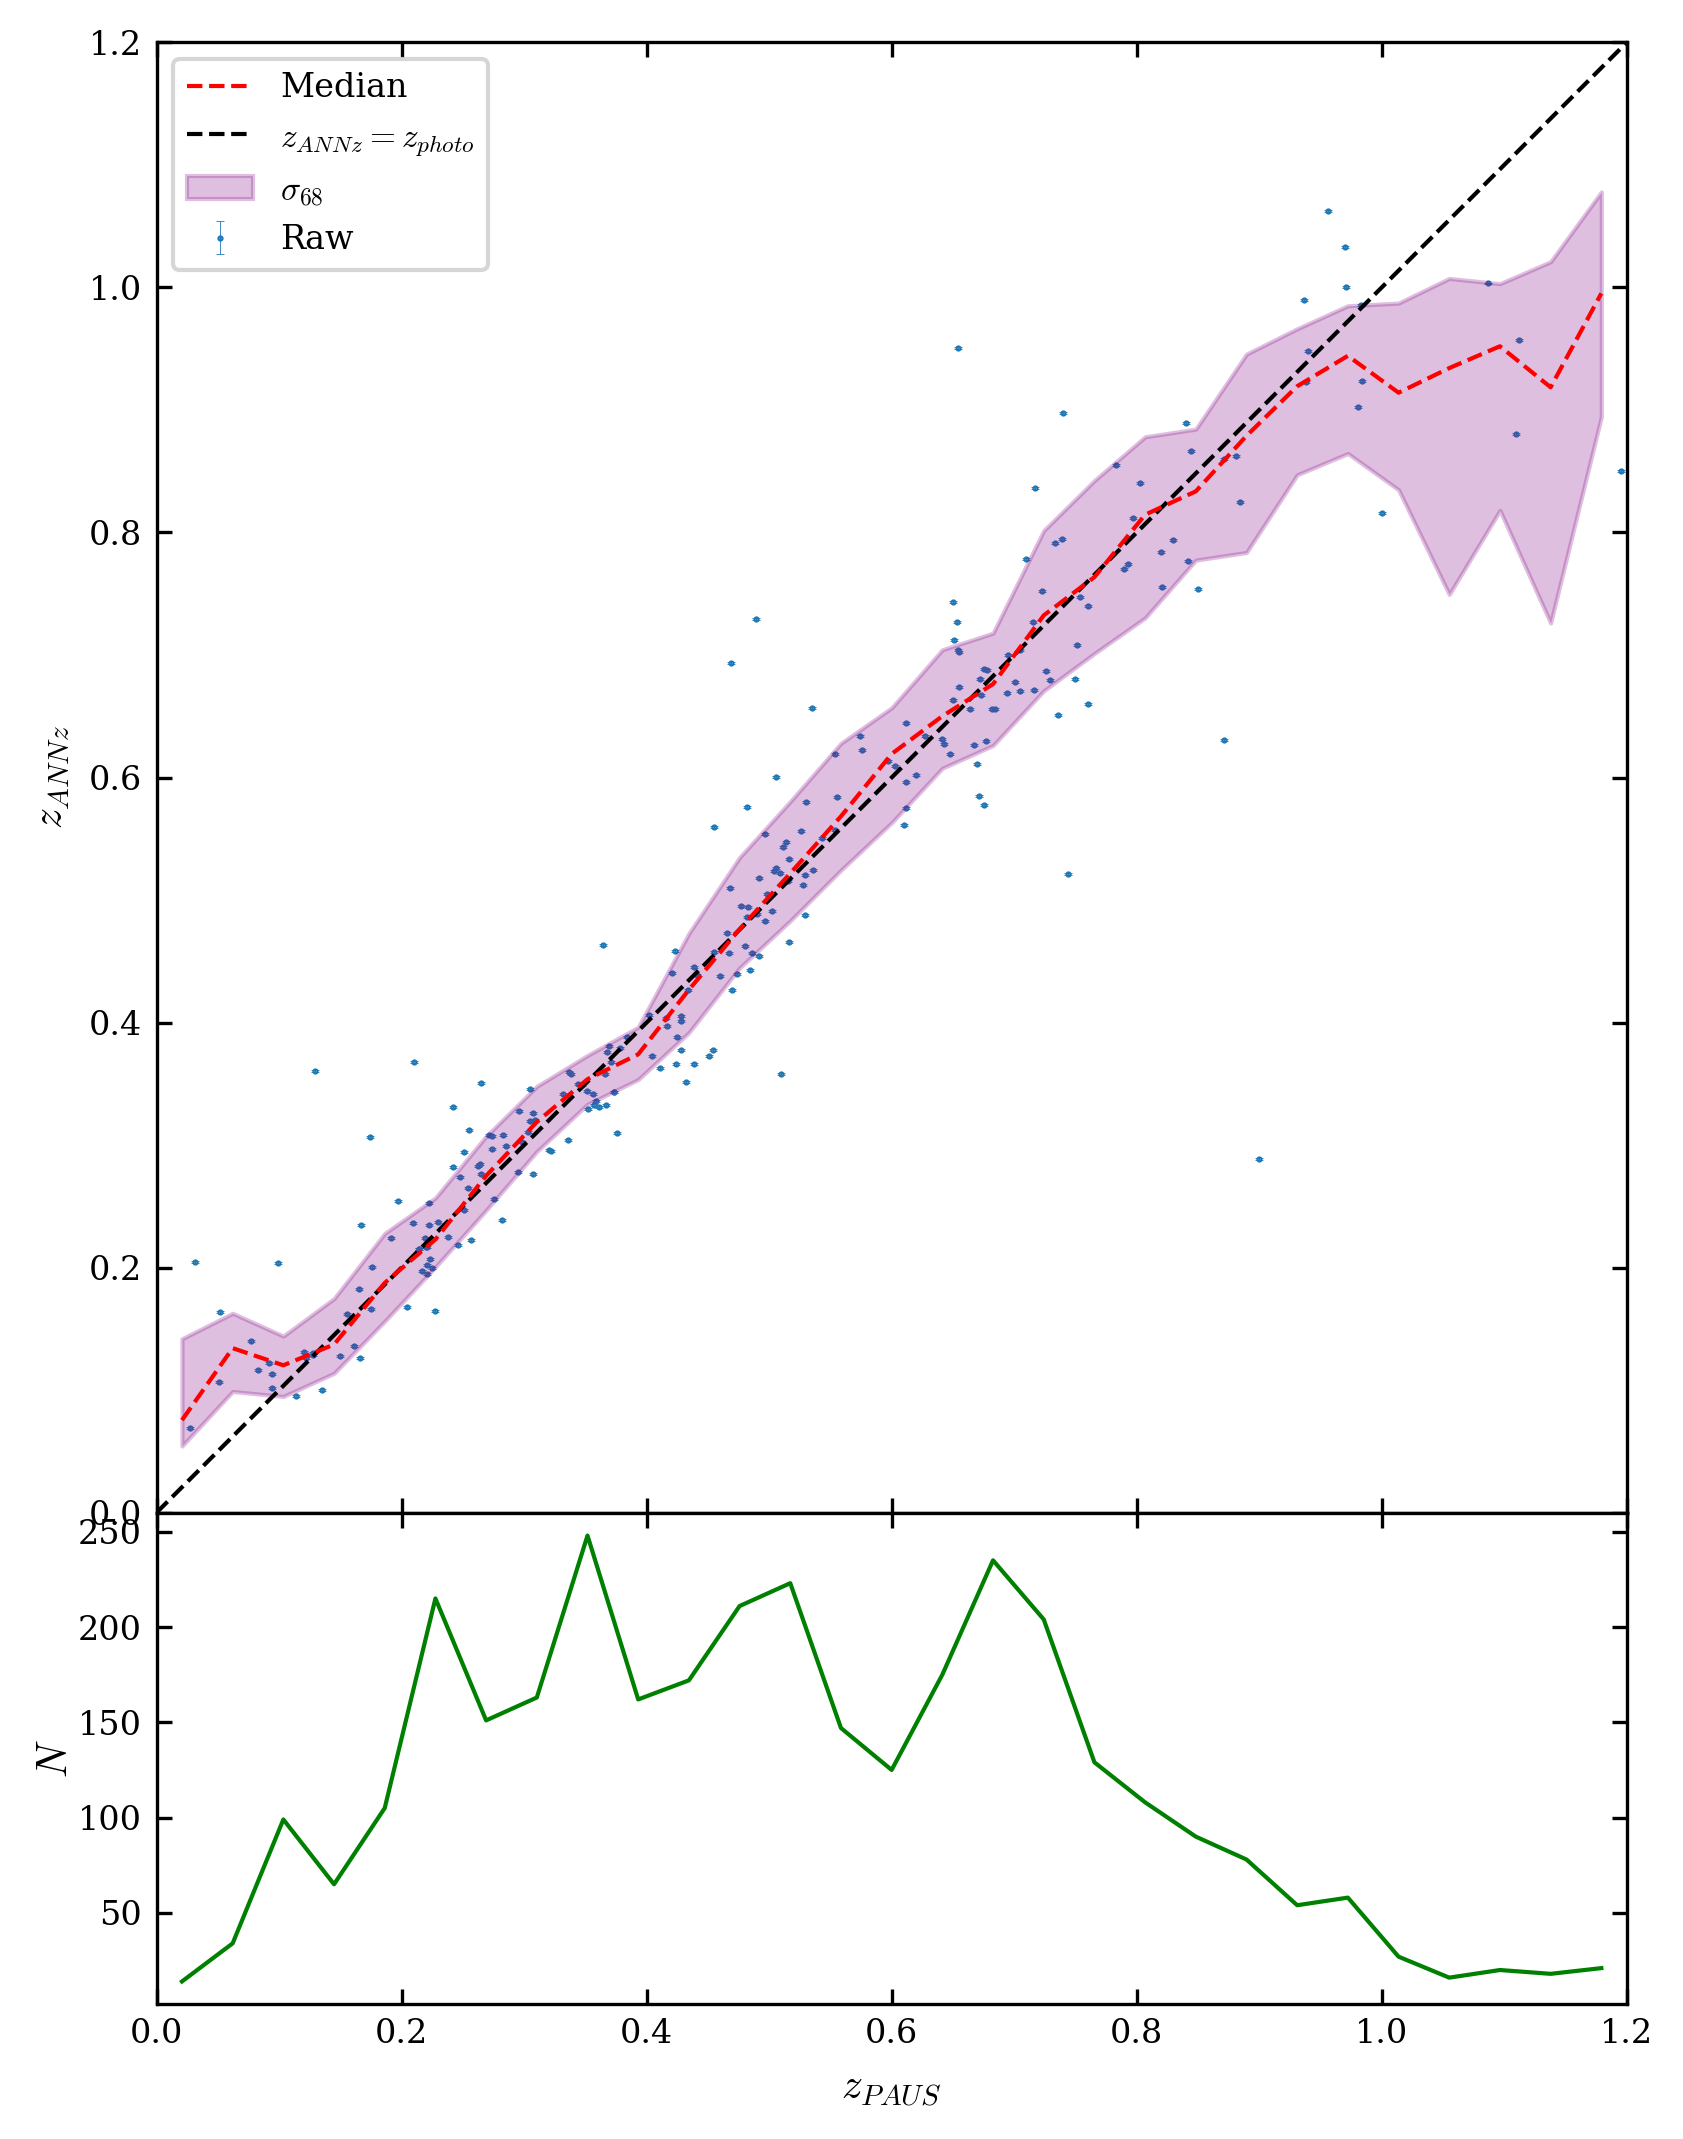

In [9]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performace (PAUS_advanced11, BDT)

In [10]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced11/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 6.60e-03 
st. dev of normed error                       = 0.090
Percentage of 'catastrophic' outliers         = 8.643%
half width of 68th percentile of normed error = 0.065


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


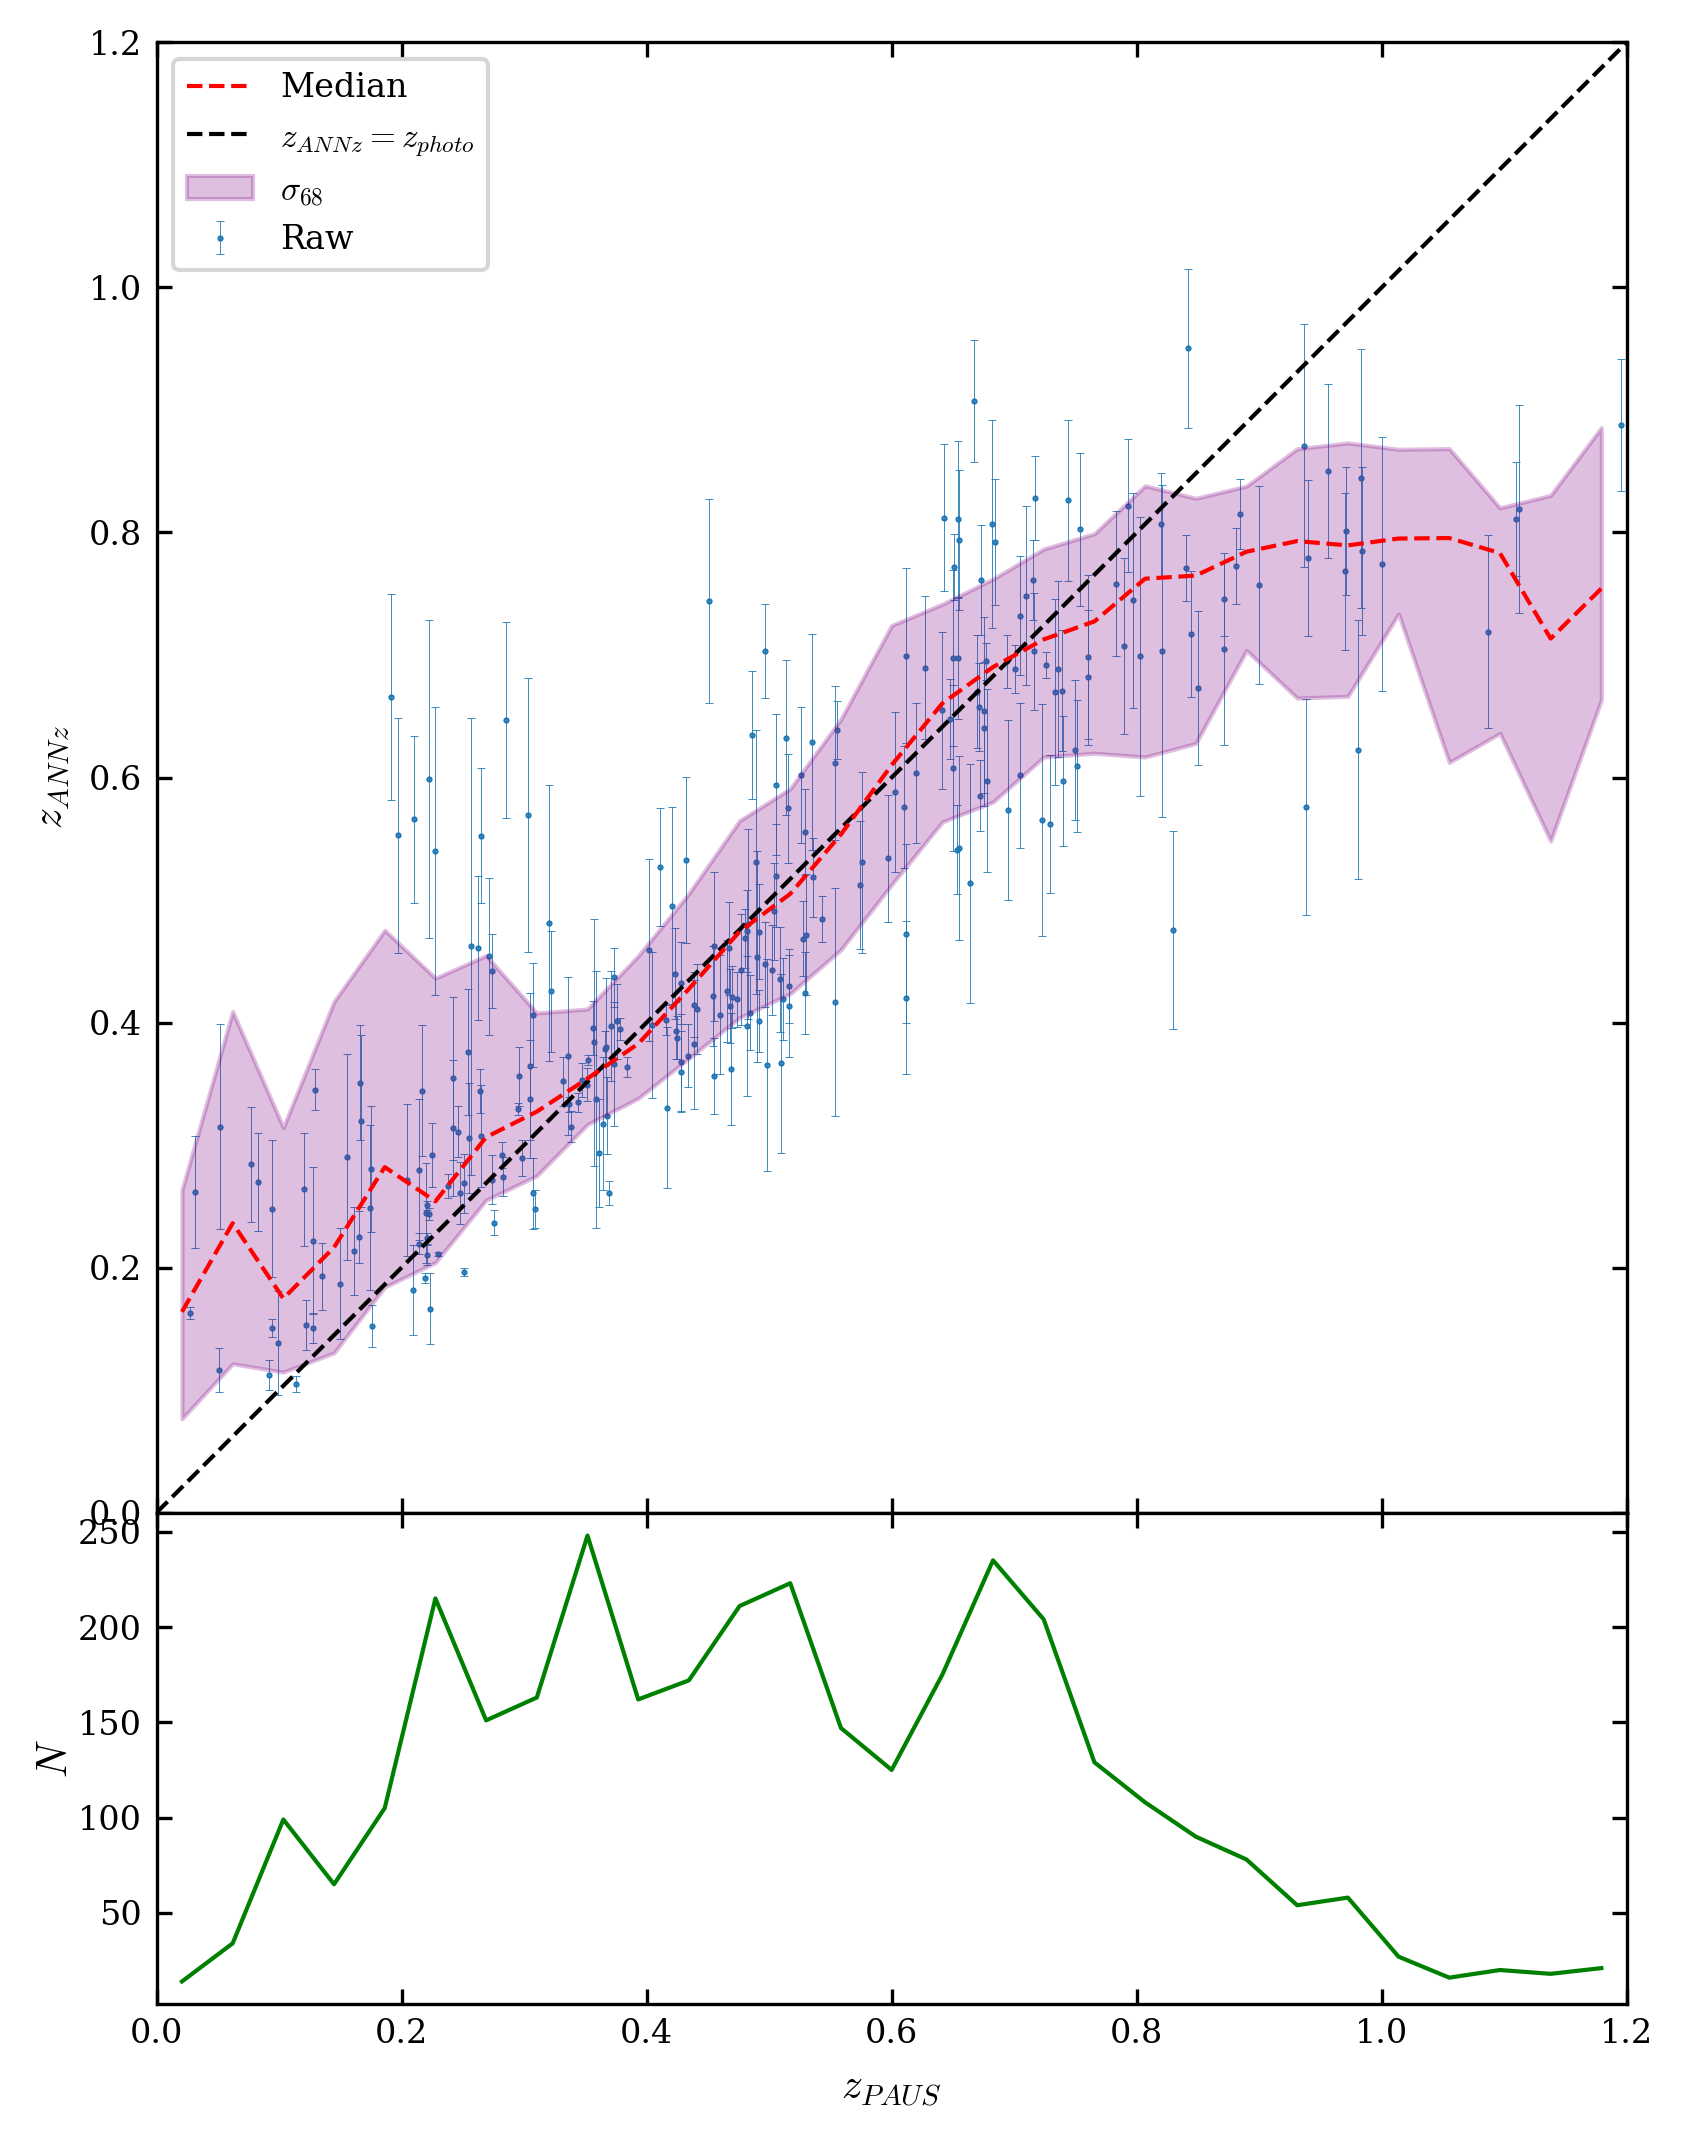

In [11]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performace (PAUS_advanced12, BDT)

In [12]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced12/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 8.50e-04 
st. dev of normed error                       = 0.039
Percentage of 'catastrophic' outliers         = 1.129%
half width of 68th percentile of normed error = 0.024


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


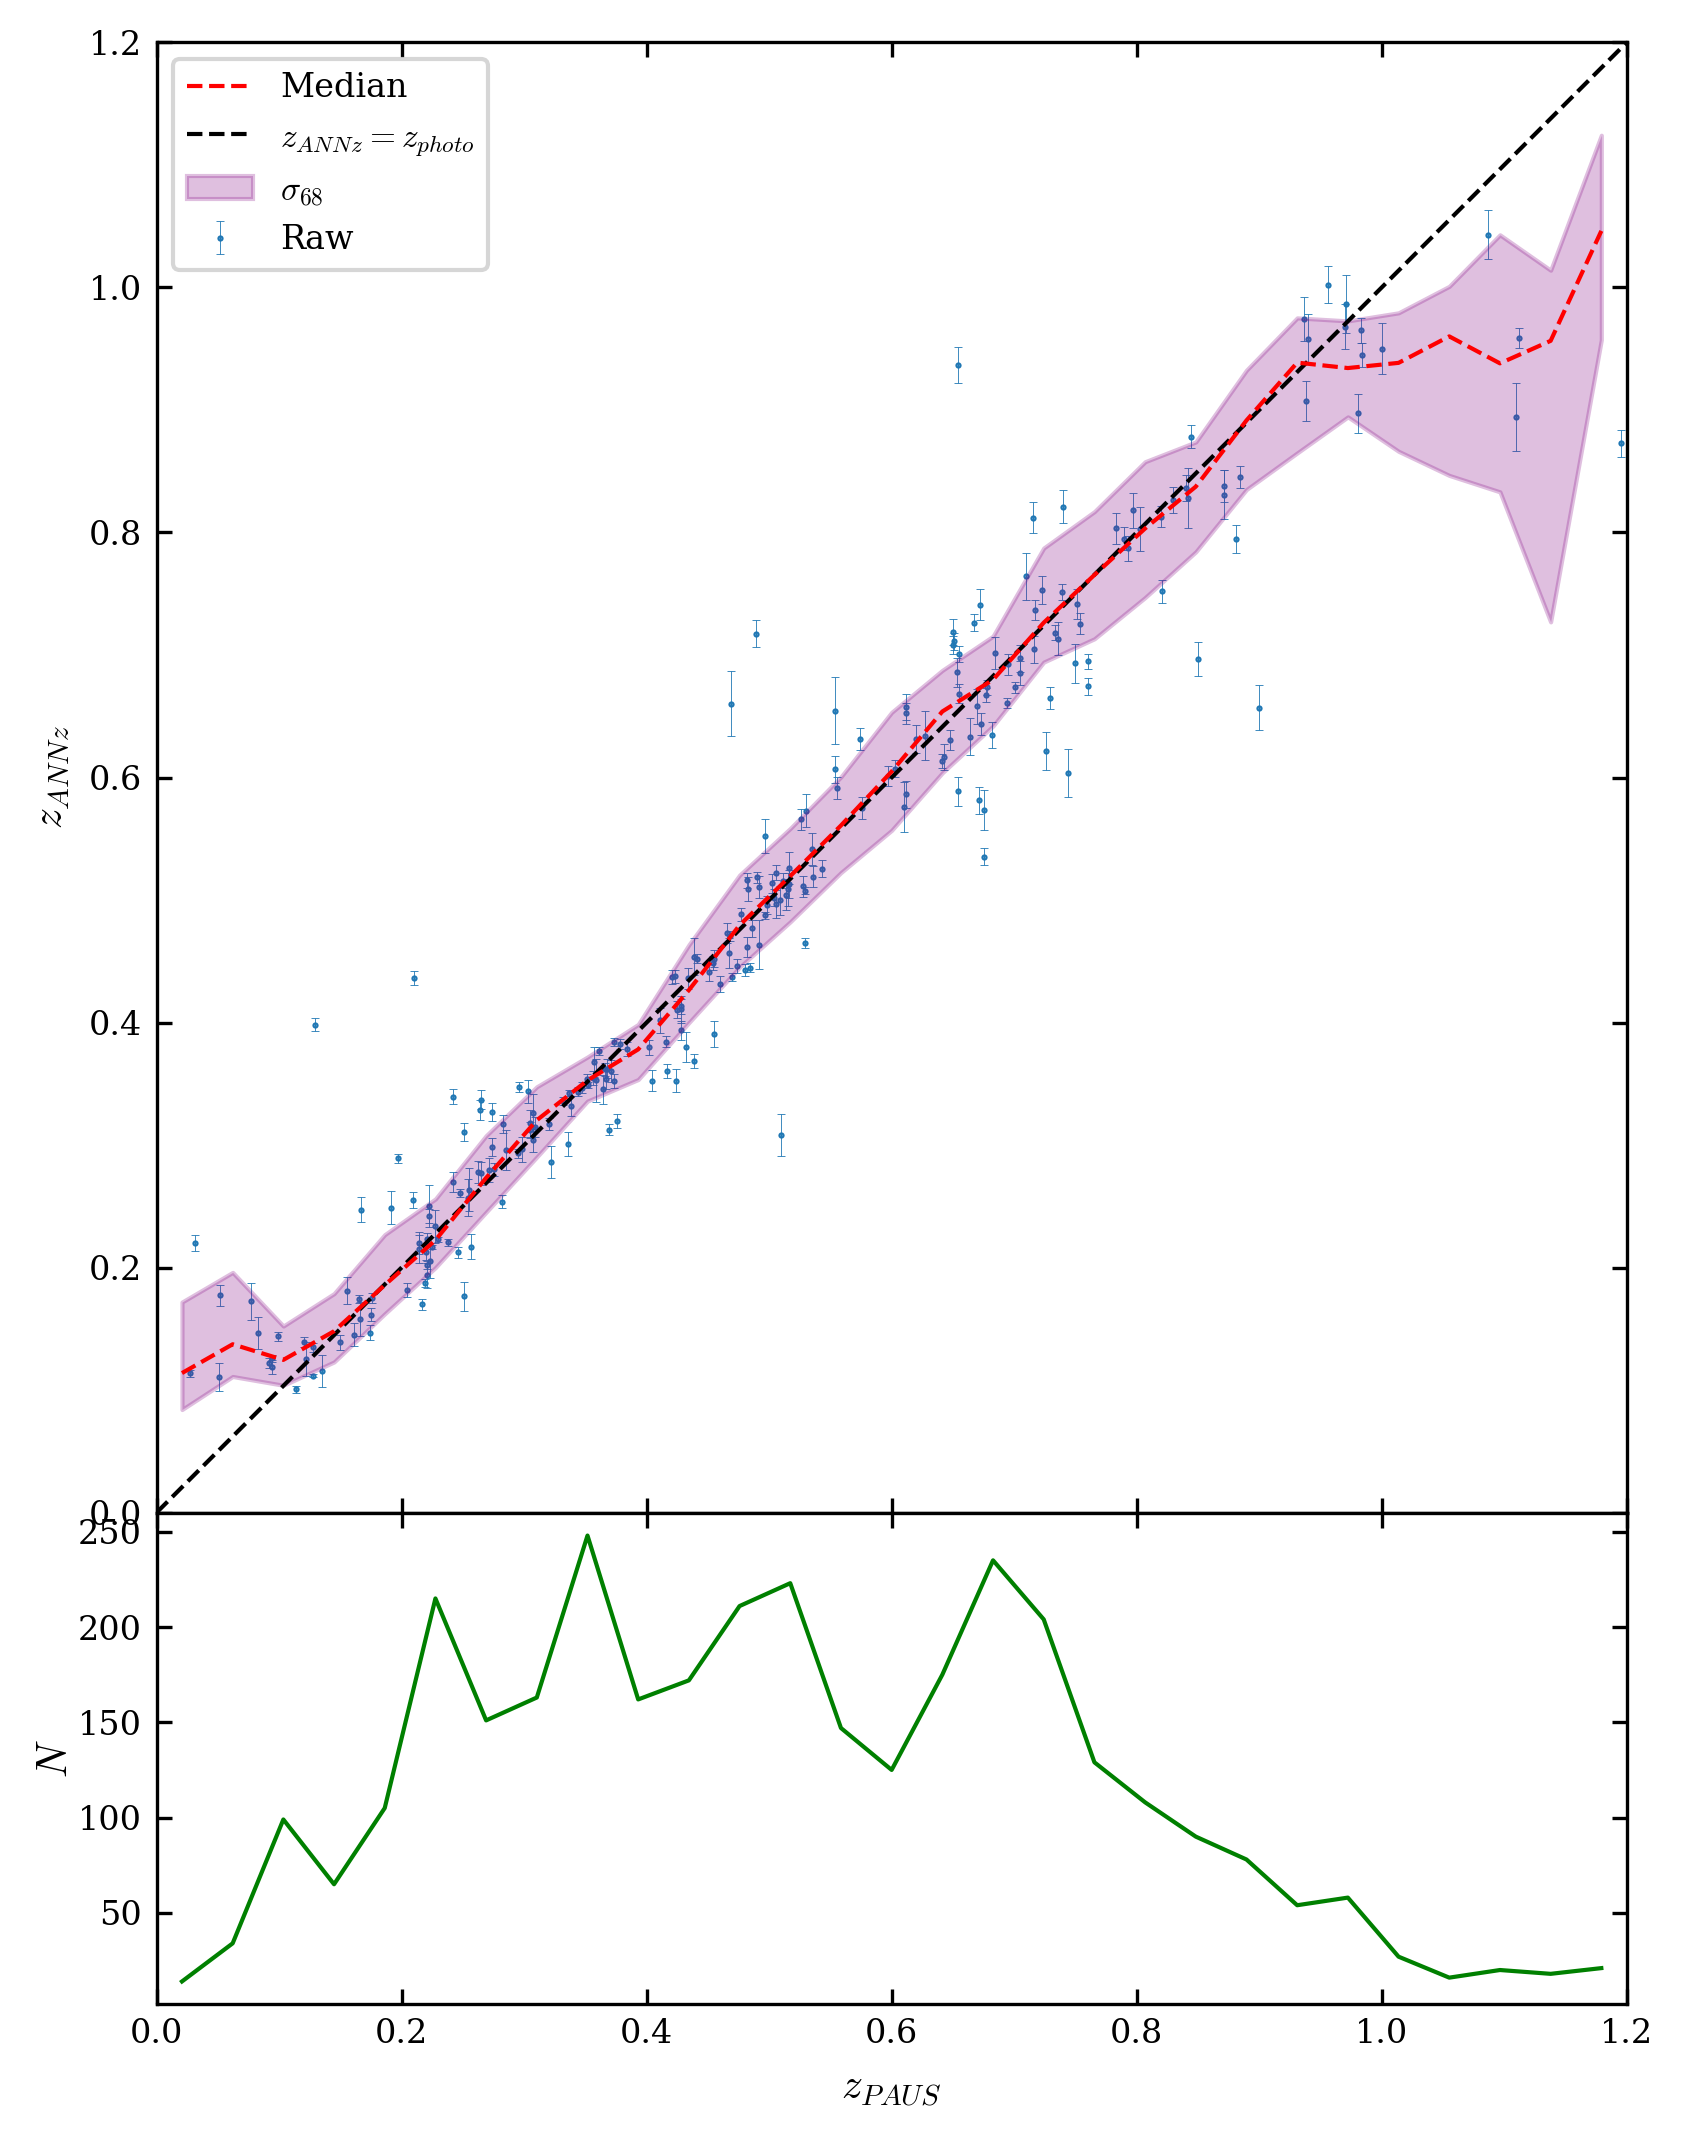

In [13]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# ANNz run performace (PAUS_advanced13, BDT)

In [14]:
ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced13/ANNZ_randomReg_0000.csv',header=0)
z_annz = ML_DATA['F:ANNZ_best']
z_paus = ML_DATA['F:zb']
z_annz_errors = ML_DATA['F:ANNZ_best_err']
# z_annz_errors = ML_DATA['F:ANNZ_best_err']

# ML_input = pd.read_csv('../../Data/ANNz_data5b.csv',header=0)

error = z_annz - z_paus
normed_error = error / (1+z_paus)

outliers_idx = abs(normed_error) > 0.15
out_perc = outliers_idx.sum()/outliers_idx.size *100

print("\
Mean normed error                             = {:1.2e} \n\
st. dev of normed error                       = {:.3f}\n\
Percentage of 'catastrophic' outliers         = {:.3f}%\n\
half width of 68th percentile of normed error = {:.3f}"\
.format(normed_error.mean(),np.std(normed_error),out_perc,(ub68(normed_error)-lb68(normed_error))/2))

Mean normed error                             = 8.50e-04 
st. dev of normed error                       = 0.039
Percentage of 'catastrophic' outliers         = 1.129%
half width of 68th percentile of normed error = 0.024


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


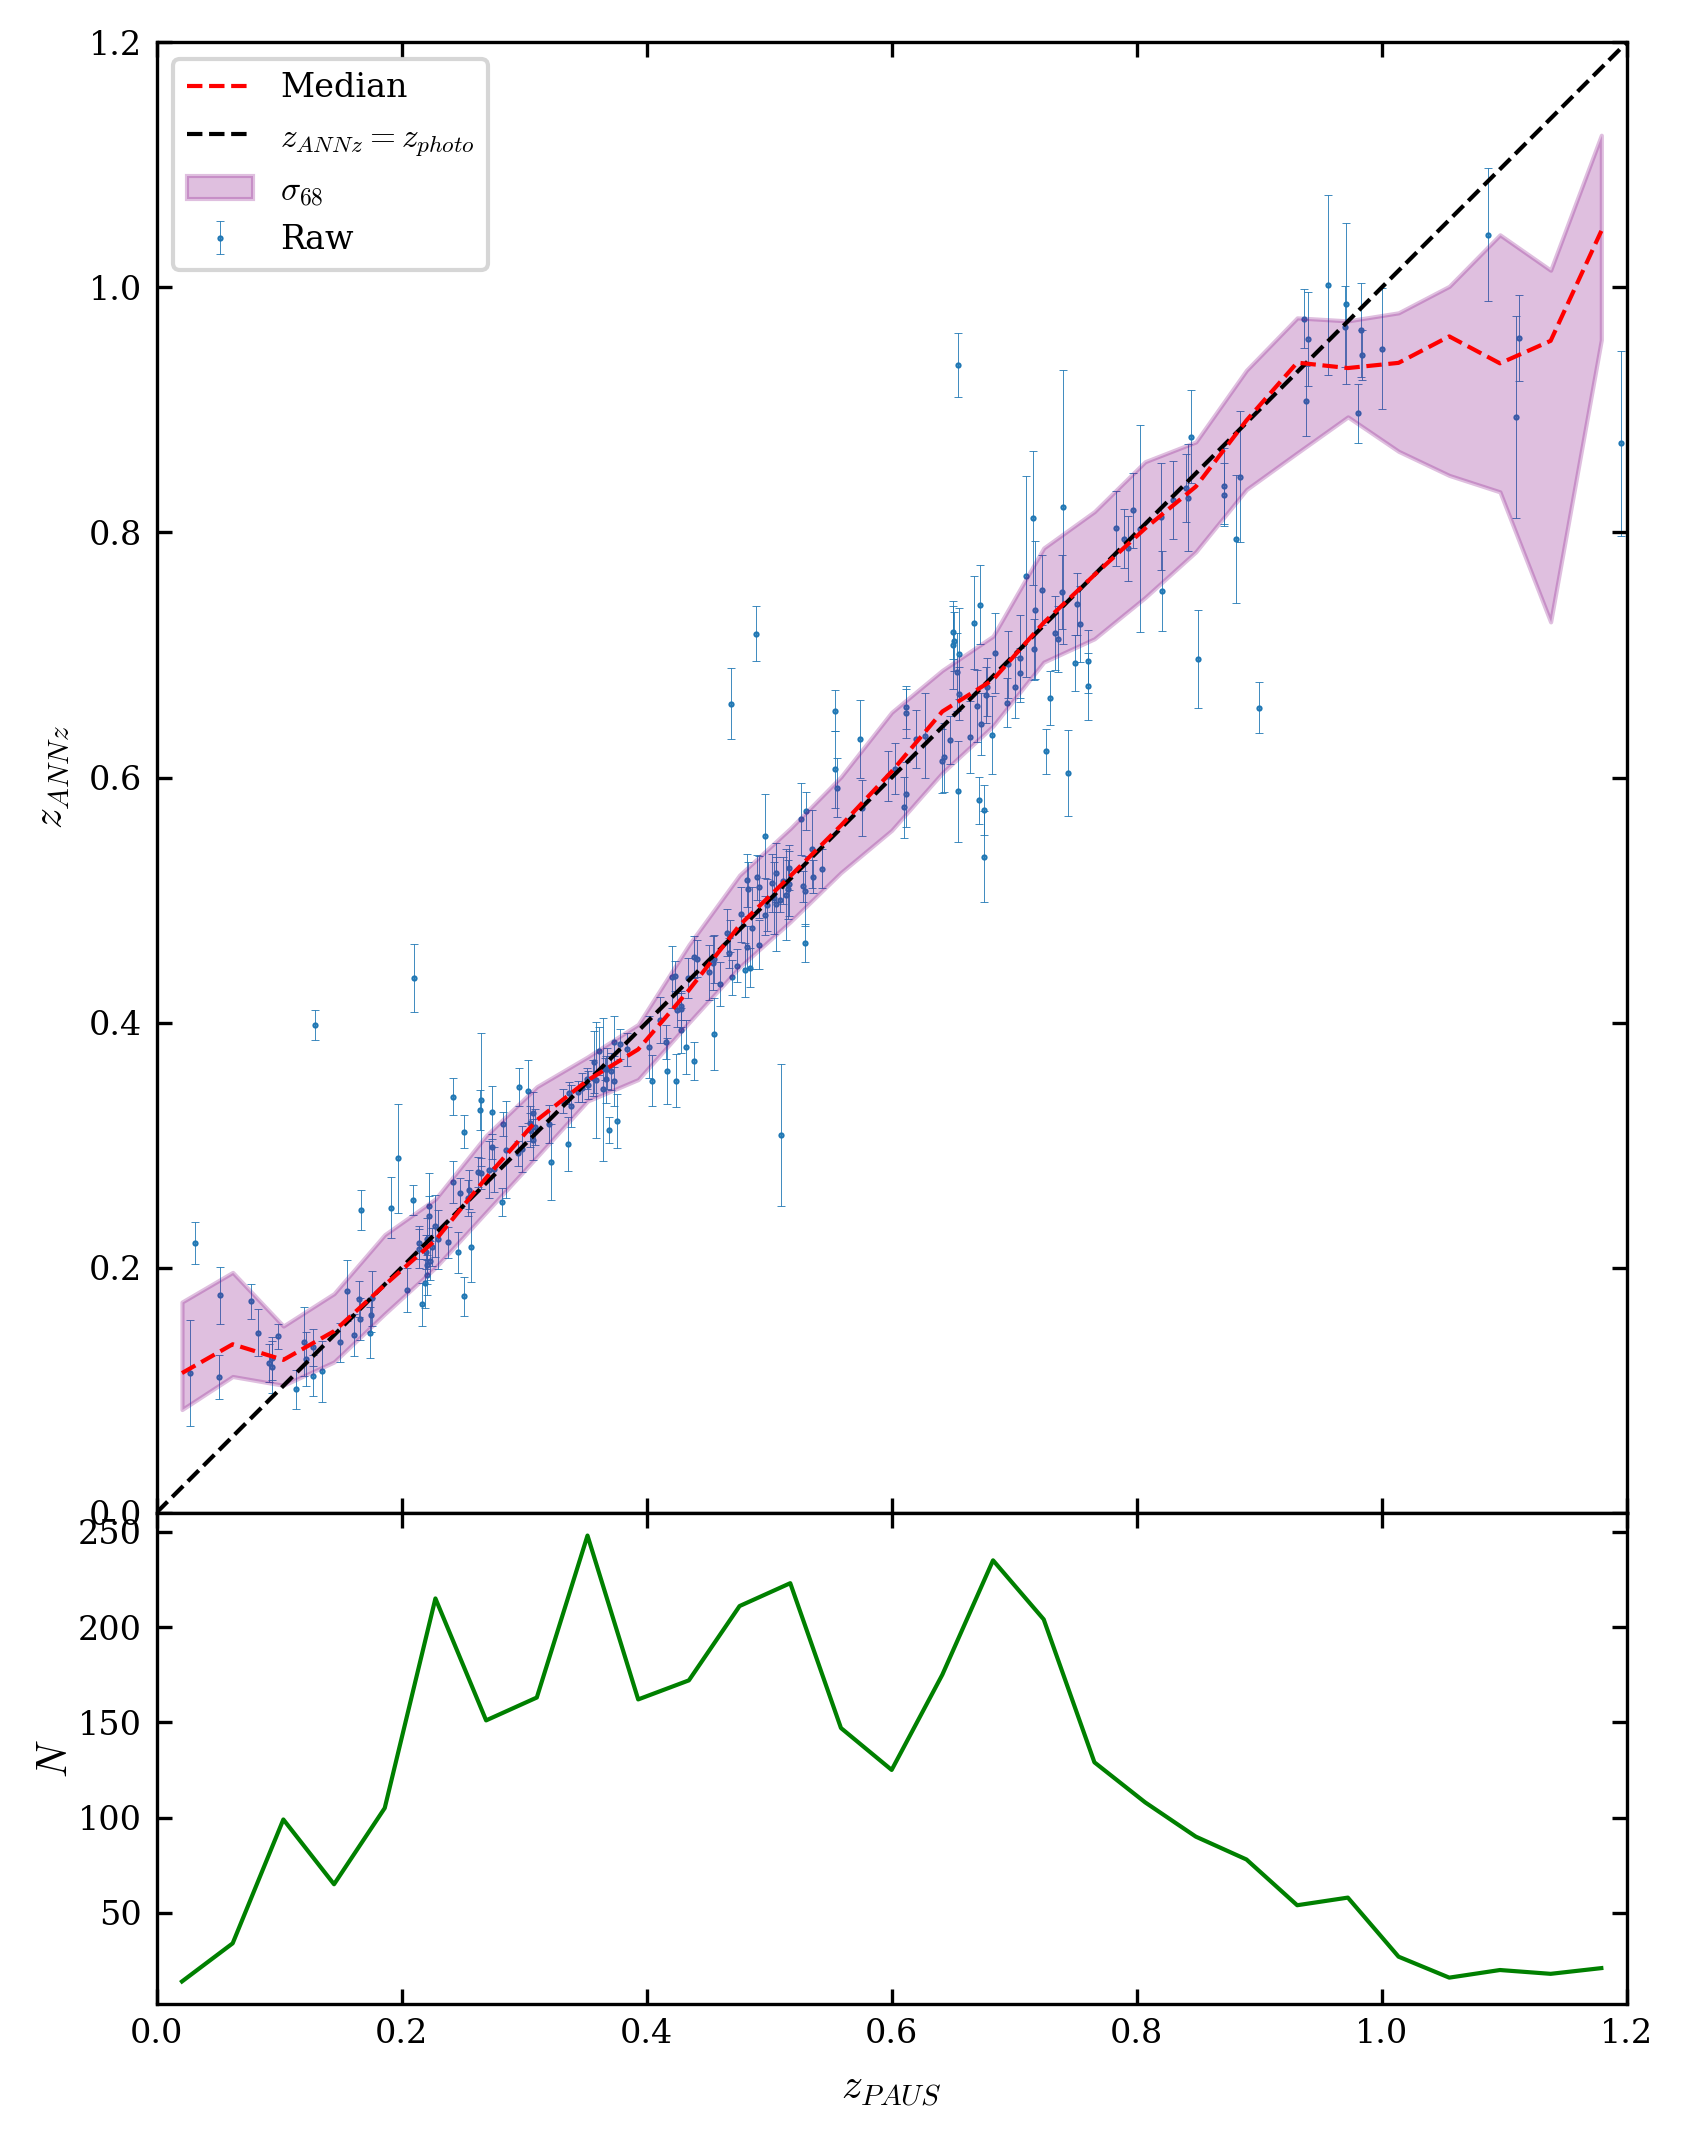

In [15]:
# ML_DATA = pd.read_csv('../../ML runs/PAUS_advanced3/regres/eval_nFile0/ANNZ_randomReg_0000.csv',header=0)
# ML_DATA
# print(ML_DATA.shape)
N_points = 250
# indices = np.random.choice(ML_DATA.shape[0],N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus.loc[indices],z_annz.loc[indices],yerr=z_annz_errors.loc[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{PAUS}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()